In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
from scipy.optimize import curve_fit
import os, sys
import warnings

def station_hit_probability(x : np.ndarray, efficiency : float, prob_50 : float, scale : float) -> np.ndarray :
    return np.clip(efficiency * (1 - 1 / (1 + np.exp(-scale * (x - prob_50))) ), 0, 1)

def station_hit_probability_error(x : np.ndarray, pcov : np.ndarray, efficiency : float, prob_50 : float, scale : float) -> np.ndarray :

    errors = np.zeros_like(x)

    d_eff = lambda u : station_hit_probability(u, efficiency, prob_50, scale)
    d_prob_50 = lambda u : efficiency * scale * np.exp(scale * (u + prob_50)) / (np.exp(prob_50 * scale) + np.exp(scale * u))**2
    d_scale = lambda u : efficiency * (prob_50 - u) * np.exp(scale * (prob_50 + u)) / (np.exp(prob_50 * scale) + np.exp(scale * u))**2

    for i, X in enumerate(x):
        gradient = np.array([d_eff(X), d_prob_50(X), d_scale(X)])
        errors[i] += np.sqrt(gradient.T @ pcov @ gradient)

    return errors

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


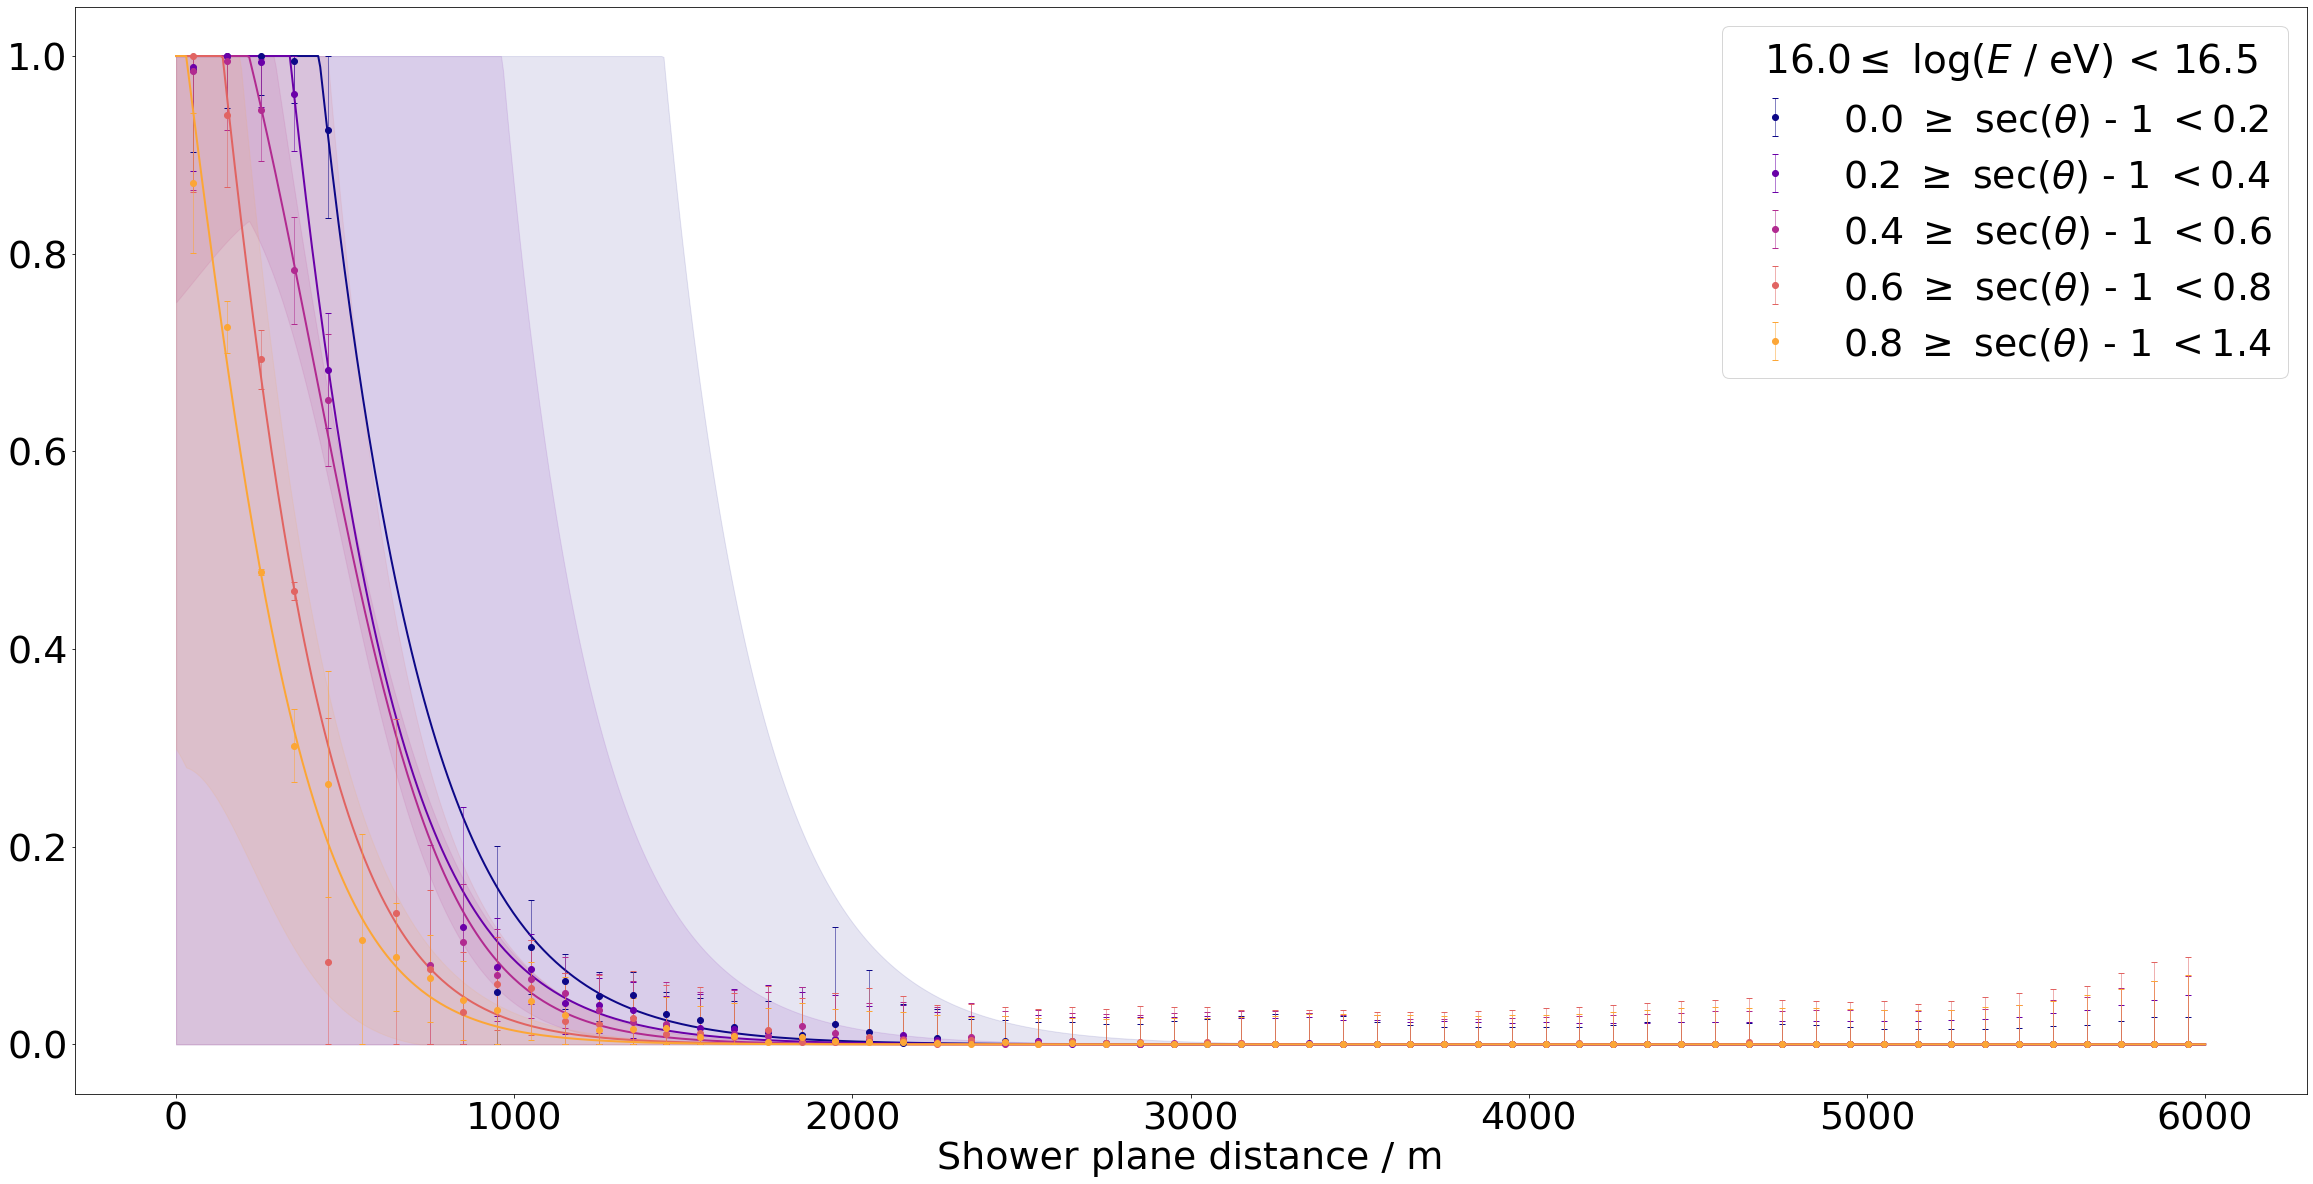

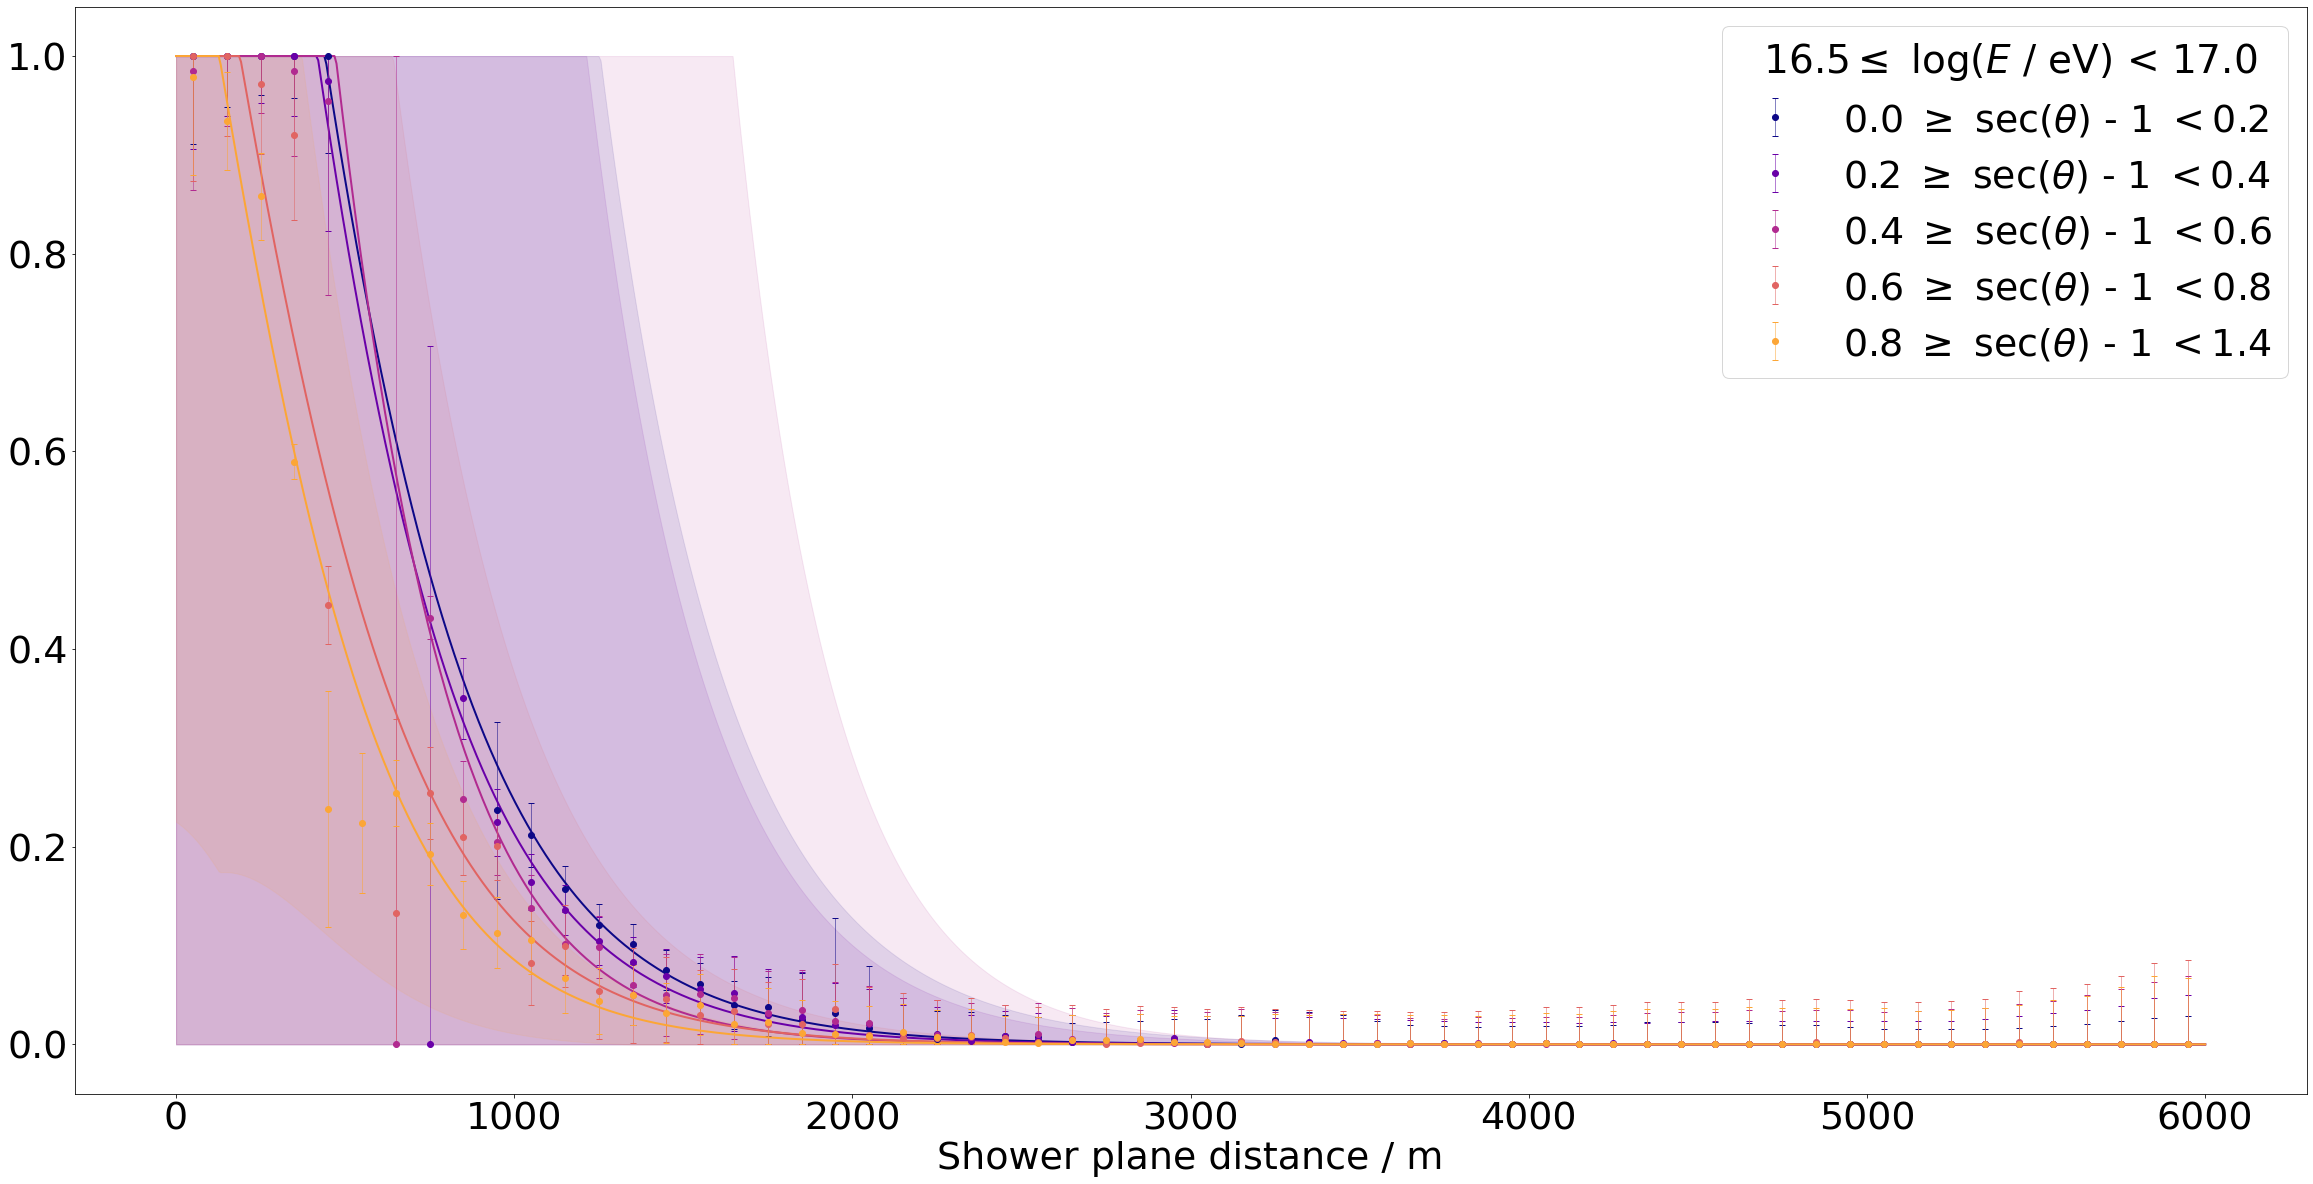

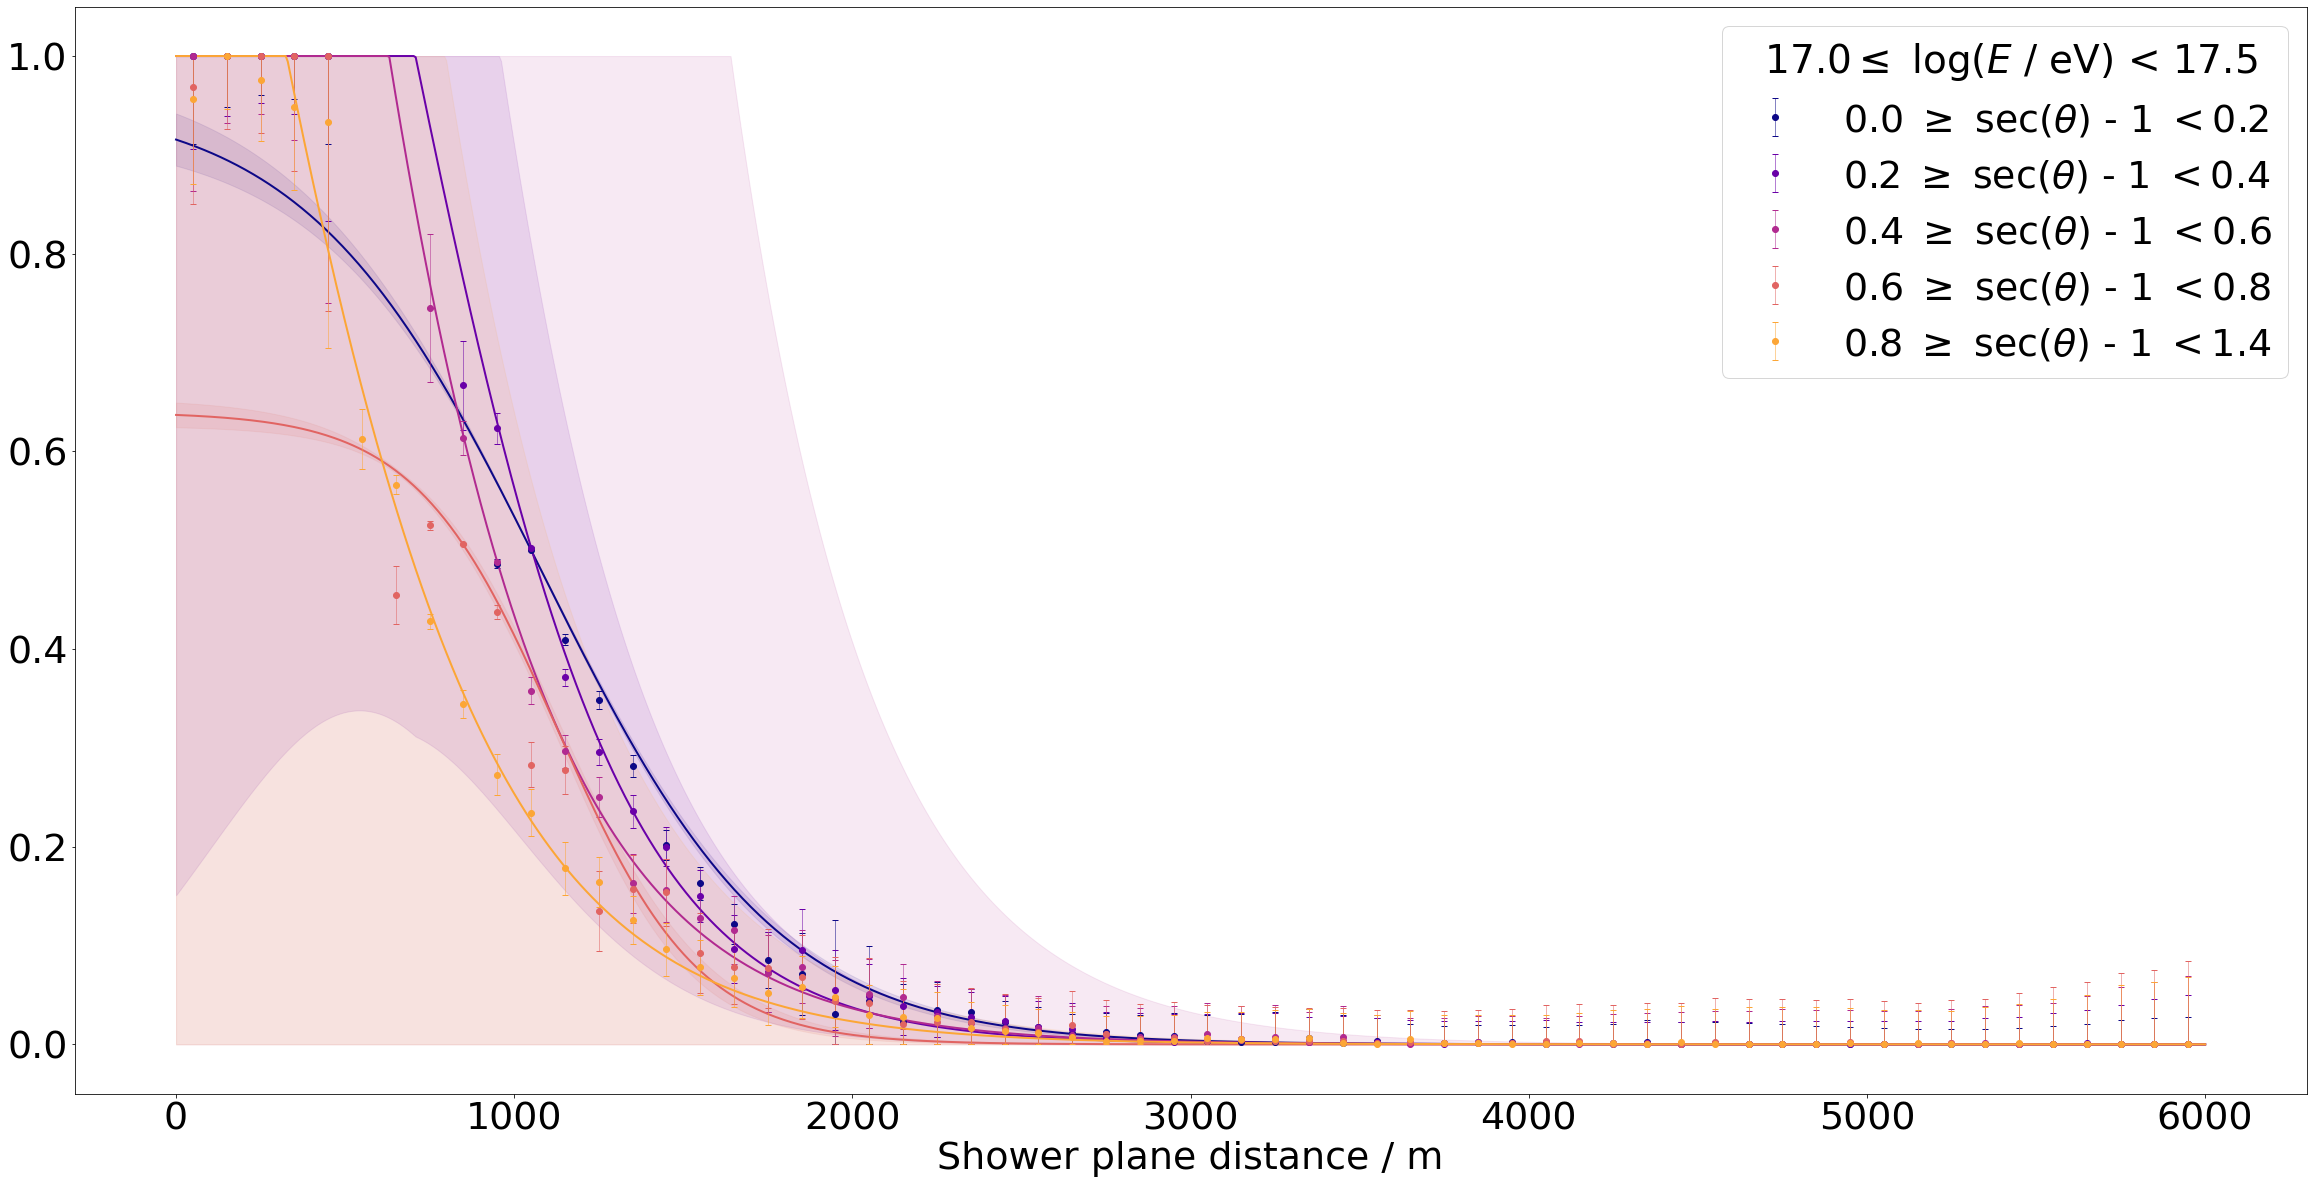

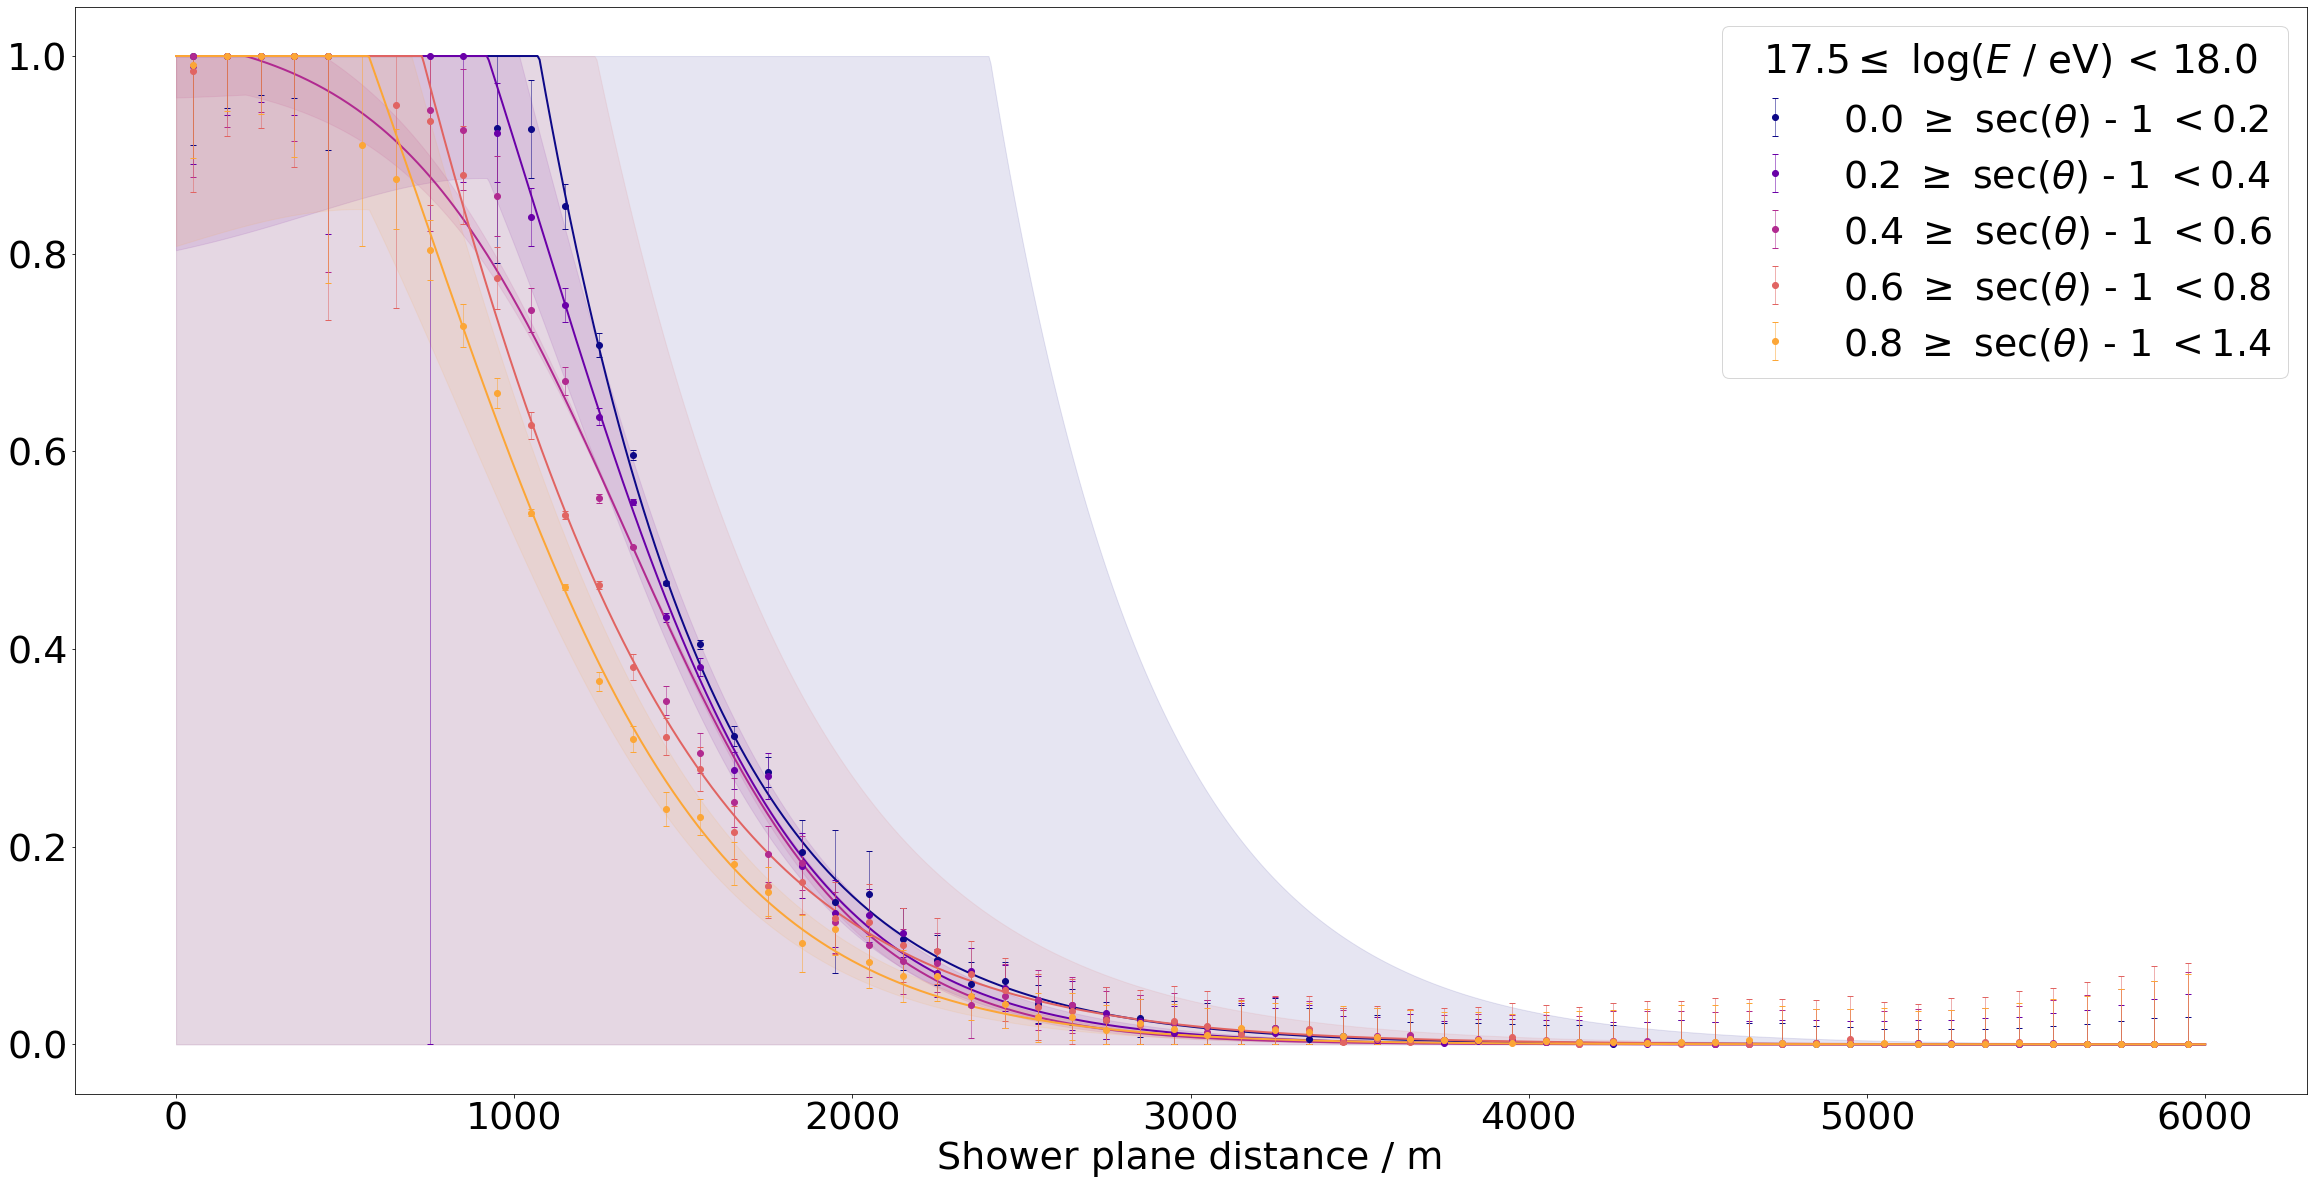

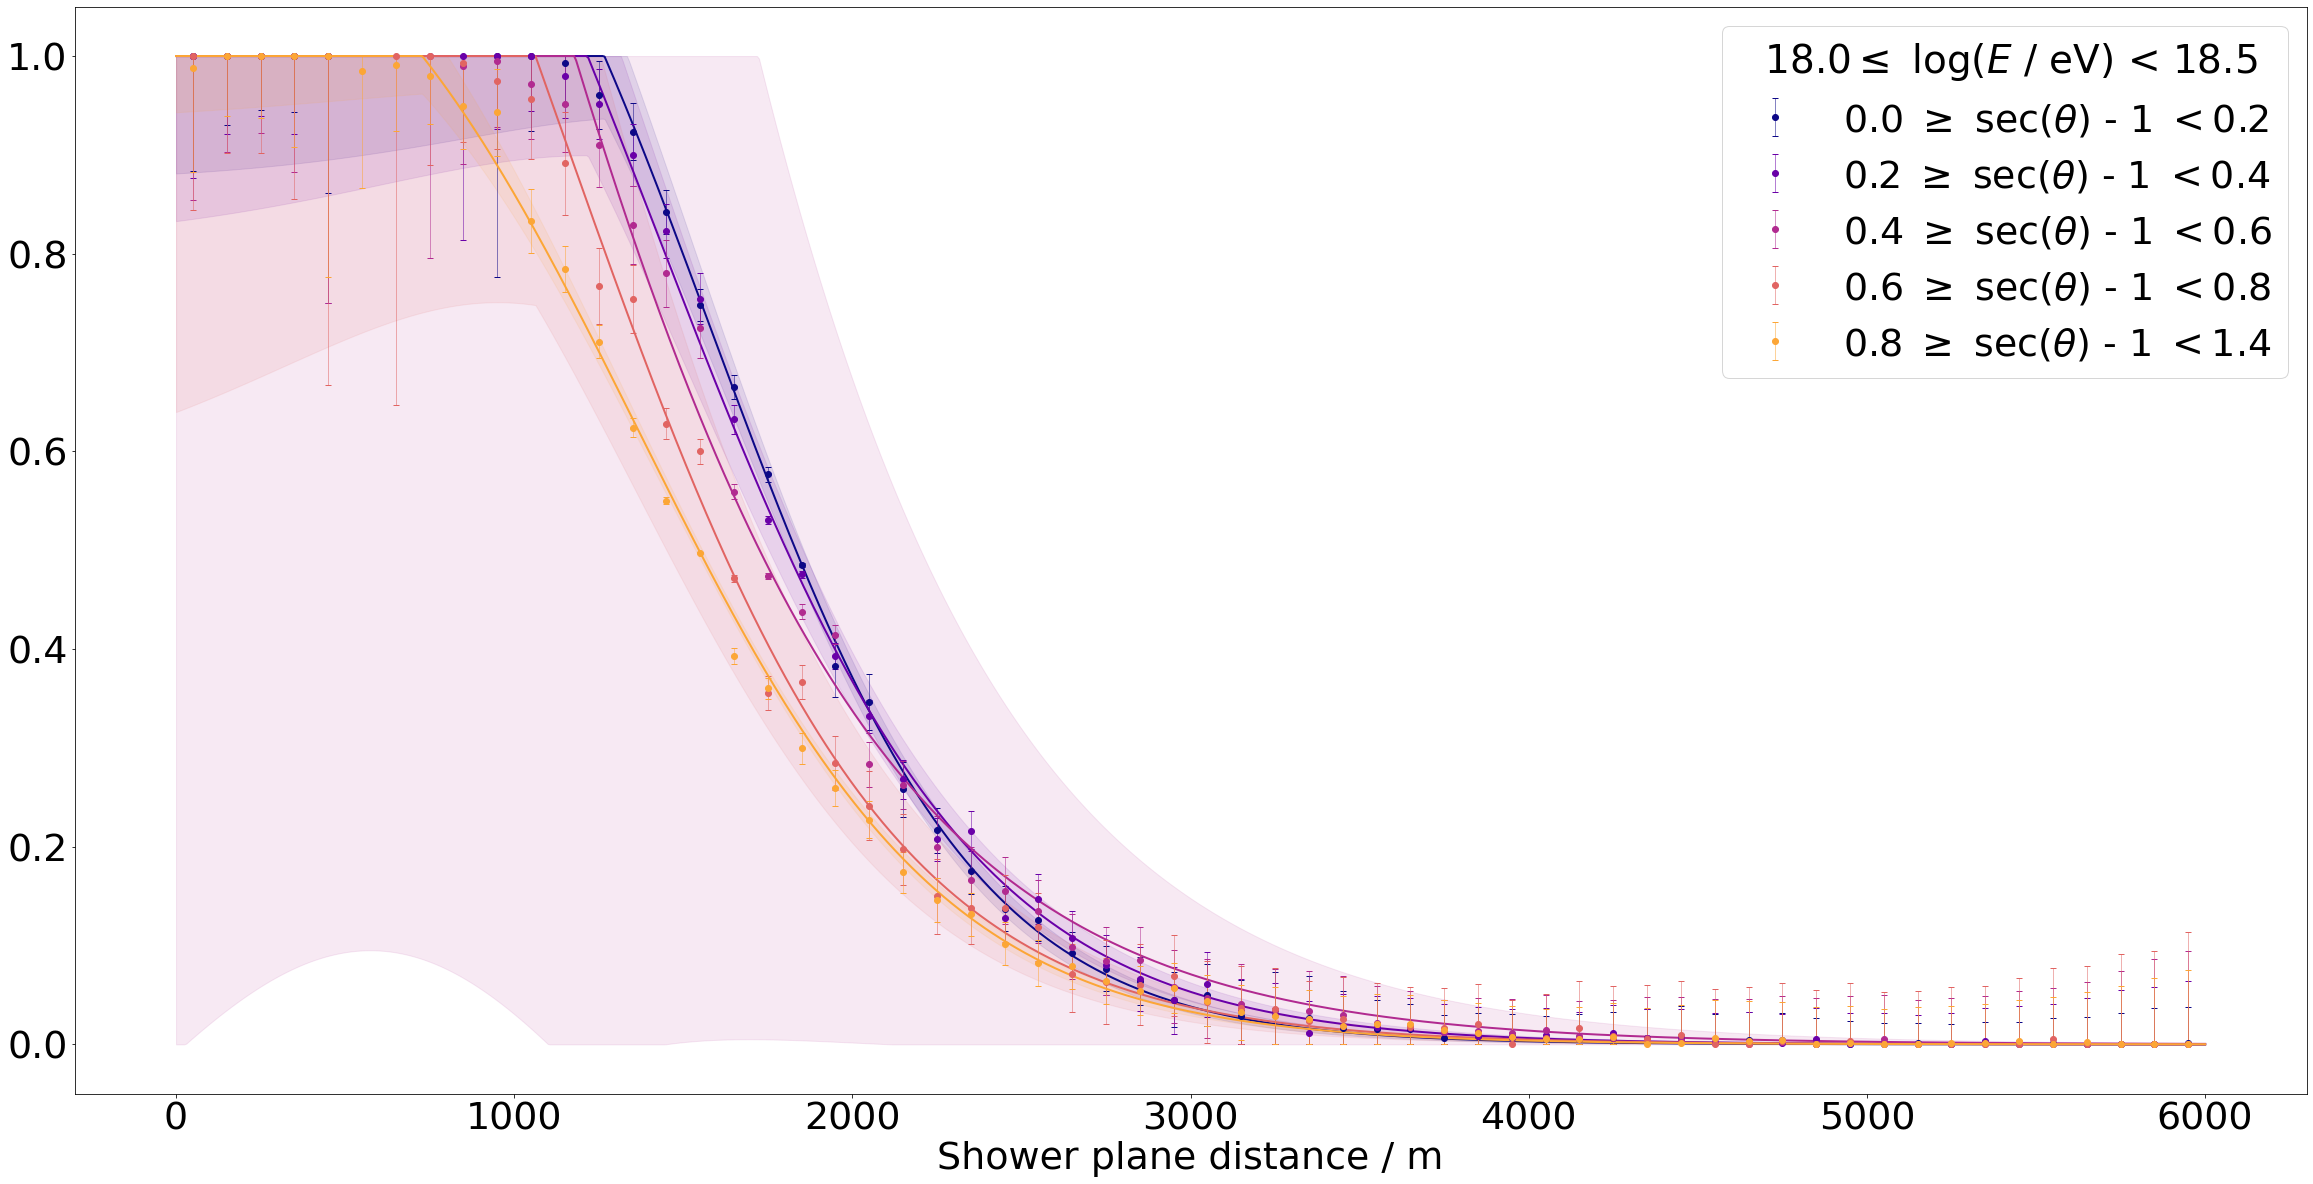

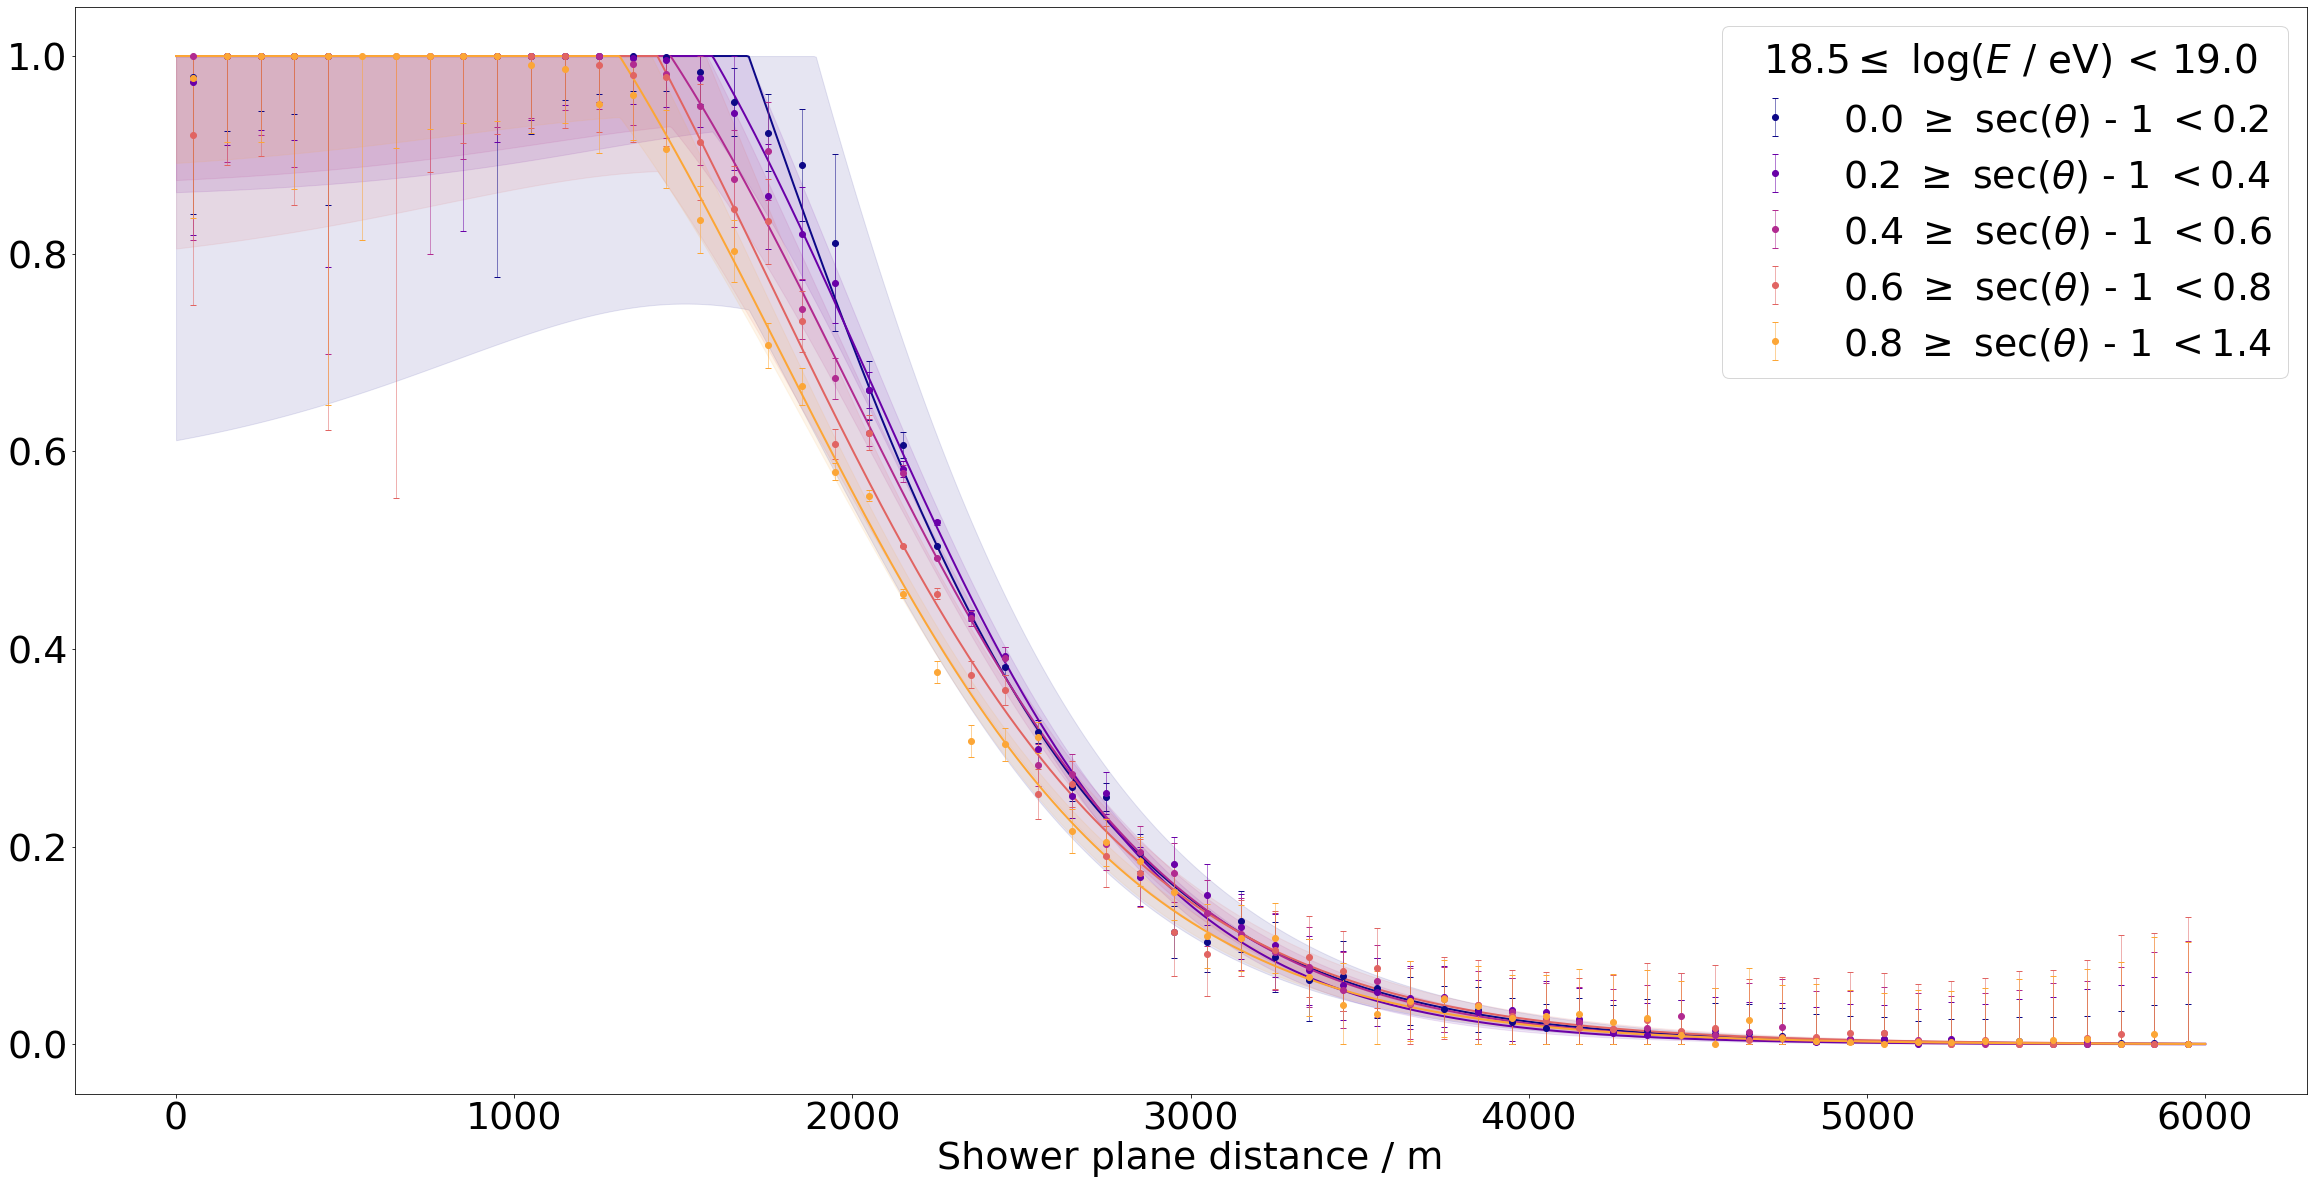

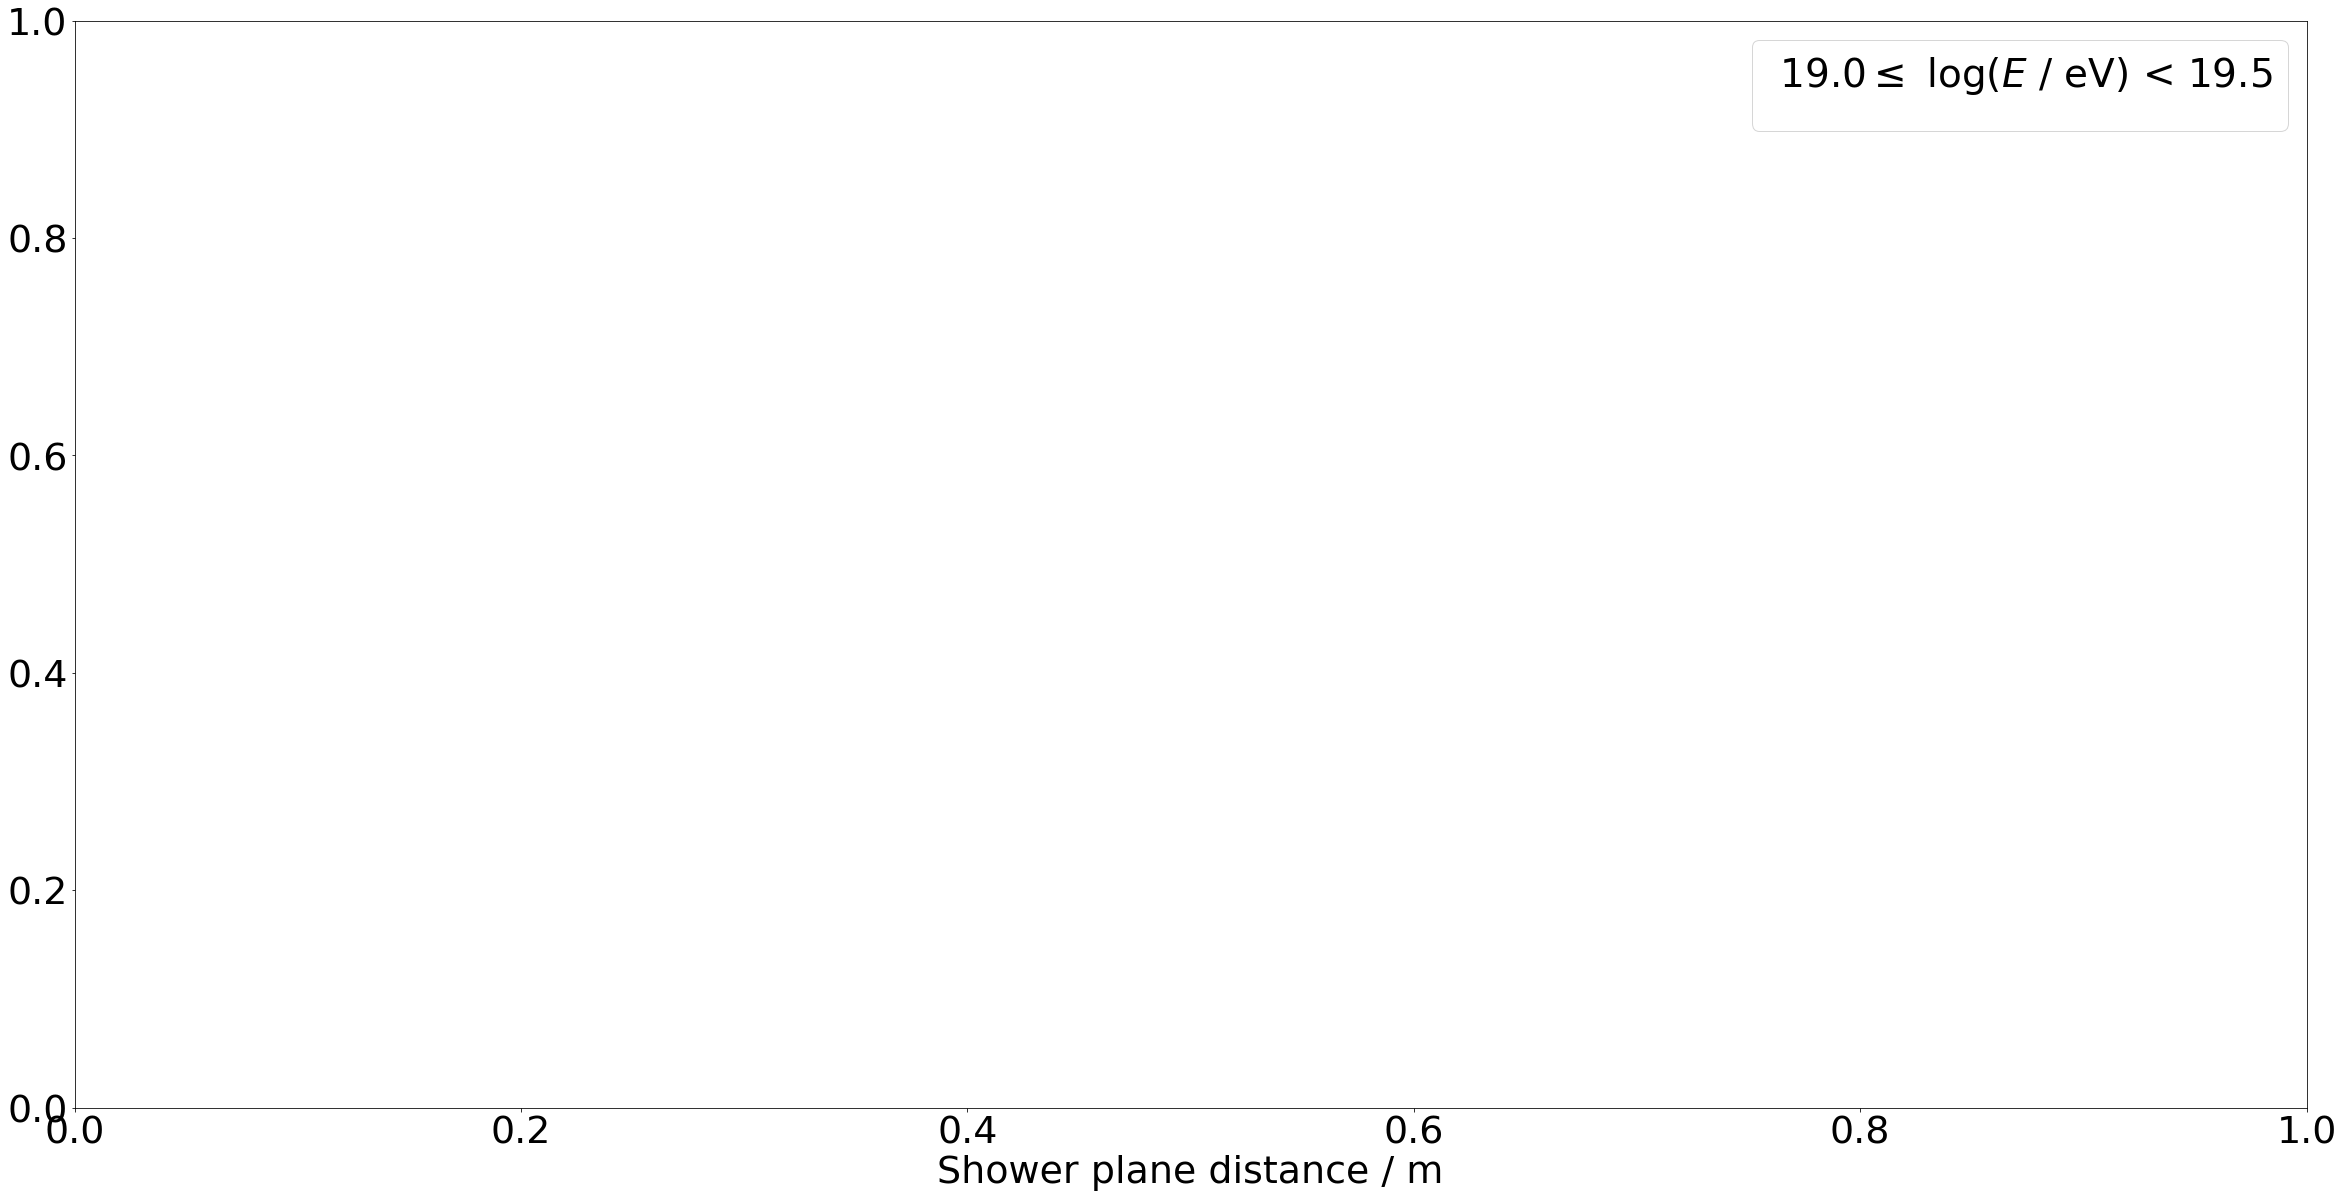

In [6]:
root_path = "/cr/tempdata01/filip/QGSJET-II/LDF/BINNED/"

colormap = cmap.get_cmap("plasma")
plt.rcParams["figure.figsize"] = [40, 20]
# plt.rcParams["figure.figsize"] = [4, 2]
plt.rcParams["font.size"] = 38
warnings.simplefilter("ignore", RuntimeWarning)

all_popt = []
t_labels = ["0.0", "0.2", "0.4", "0.6", "0.8", "1.4"]
e_bins = np.array([16, 16.5, 17, 17.5, 18, 18.5, 19])
t_bins = np.array([0, 33, 44, 51, 56])

axes = []

for _ in range(7):
    fig= plt.figure()
    axes.append(plt.gca())

for file in os.listdir(root_path):

    if not file.endswith(".csv"): continue
    spd, hits, misses = np.loadtxt(root_path + file, unpack = True)
    spd, hits, misses = spd[:-5], hits[:-5], misses[:-5]
    efficiency_err = np.clip(1/(hits + misses)**2 * np.sqrt( hits**3 + misses**3 - 2 * np.sqrt((hits * misses)**3) ), 1e-5, 1)
    efficiency = hits / (hits + misses)
    upper = np.clip(efficiency + efficiency_err, 0, 1)
    lower = np.clip(efficiency - efficiency_err, 0, 1)

    c = colormap(np.argmin(abs(float(file[:-4].split("_")[3]) - t_bins)) / len(t_bins))
    ax = axes[np.argmin(abs(float(file[:-4].split("_")[0]) - e_bins))]

    t_label = t_labels[np.argmin(abs(float(file[:-4].split("_")[3]) - t_bins))] + r" $\geq$ sec($\theta$) - 1 $< $" + t_labels[np.argmin(abs(float(file.split("_")[3]) - t_bins)) + 1]
    ax.errorbar(spd - 50, efficiency, yerr = [efficiency - lower, upper - efficiency], capsize = 3, fmt = "o", elinewidth = 0.5, color = c, label = t_label)

    filter = [not np.isnan(item) and not np.isinf(item) for item in efficiency]
    popt, pcov = curve_fit(station_hit_probability, (spd - 50)[filter], efficiency[filter], 
                                                                p0 = [1, 1000, 1e-6],
                                                                bounds = ([0, 0, 0], [np.inf, 6000, 1]),
                                                                sigma = efficiency_err[filter],
                                                                absolute_sigma = True,
                                                                maxfev = 10000)
    
    all_popt.append(popt)
    
    # with open("/cr/tempdata01/filip/QGSJET-II/LDF/FITPARAM/" + file, "w") as stream:
    #     np.savetxt(stream, np.insert(popt, 0, 1))
    
    X, Y = np.linspace(0, 6e3, 1000), station_hit_probability(np.linspace(0, 6e3, 1000), *popt)
    Y_err = station_hit_probability_error(X, pcov, *popt)
    bottom, top = np.clip(Y - Y_err, 0, 1), np.clip(Y + Y_err, 0, 1)
    
    ax.plot(X, Y, color = c, lw = 2)
    ax.fill_between(X, bottom, top, color = c, alpha = 0.1)

e_bins = list(e_bins) + [19.5]

for e, ax in enumerate(axes):
    ax.legend(title = " " + str(e_bins[e]) + r"$ \leq$ log($E$ / eV) < " + str(e_bins[e + 1]), title_fontsize = 39)
    # ax.set_xlim(0, 6000)
    ax.set_xlabel("Shower plane distance / m")

warnings.simplefilter("default", RuntimeWarning)

In [36]:
def confidence_comparison(confidence_level, *args, **kwargs):

    y_max = kwargs.get("ymax", 2500)
    labels = kwargs.get("labels", None)
    energy_labels = ["16_16.5", "16.5_17", "17_17.5", "17.5_18", "18_18.5", "18.5_19", "19_19.5"]
    theta_labels = [r"$0^\circ$", r"$33^\circ$", r"$44^\circ$", r"$51^\circ$", r"$56^\circ$", r"$65^\circ$"]

    try:
        if labels and len(labels) != len(args): raise ValueError
    except:
        sys.exit("Provided labels doesn't match the provided fit parameters")

    fig, axes = plt.subplots(nrows = len(theta_labels) - 1, sharex = True, sharey = True)
    axes[0].set_title(f"Trigger characteristics for r$_{{{confidence_level * 1e2:.0f}}}$")
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    for i, fit_params in enumerate(*args):
            
            e = i // (len(energy_labels) - 2)
            t = i % (len(theta_labels) - 1)

            try:
                acc, p50, scale = fit_params
            except ValueError:
                acc, p50, scale = 1, *fit_params
                
            inverse_trigger_probability = lambda y : p50 - np.log(1 / (acc/y - 1)) / scale

            # axes[t].errorbar(e, inverse_trigger_probability(confidence_level), xerr = 0.5)
            # try:
            axes[t].scatter(e, inverse_trigger_probability(confidence_level), c = colors[0])
            # except: pass

    axes[t].set_xticks(range(7), energy_labels)

    fig.text(0.51, 0.04, 'Energy range', ha='center', fontsize = 50)
    fig.text(0.06, 0.5, 'Detection radius / m', va='center', rotation='vertical', fontsize = 50)
    
    for i, ax in enumerate(axes):
        if labels: 
            for ii, label in enumerate(labels):
                ax.scatter([], [], marker = "s", c = colors[ii], label = labels[ii])

        ax.axhline(0, c = "gray", ls = "solid", lw = 2, label = "    0% efficiency")
        ax.axhline(1500, c = "gray", ls = ":", lw = 2, label = "100% efficiency")
        ax.legend(title = theta_labels[i] + r"$\leq$ $\theta$ < " + theta_labels[i + 1], loc = "upper left", fontsize = 24)

    plt.xlim(-0.5, 6.5)
    plt.ylim(-400, y_max)

/tmp/ipykernel_3025747/2788710631.py:28: RuntimeWarning: invalid value encountered in log
  inverse_trigger_probability = lambda y : p50 - np.log(1 / (acc/y - 1)) / scale


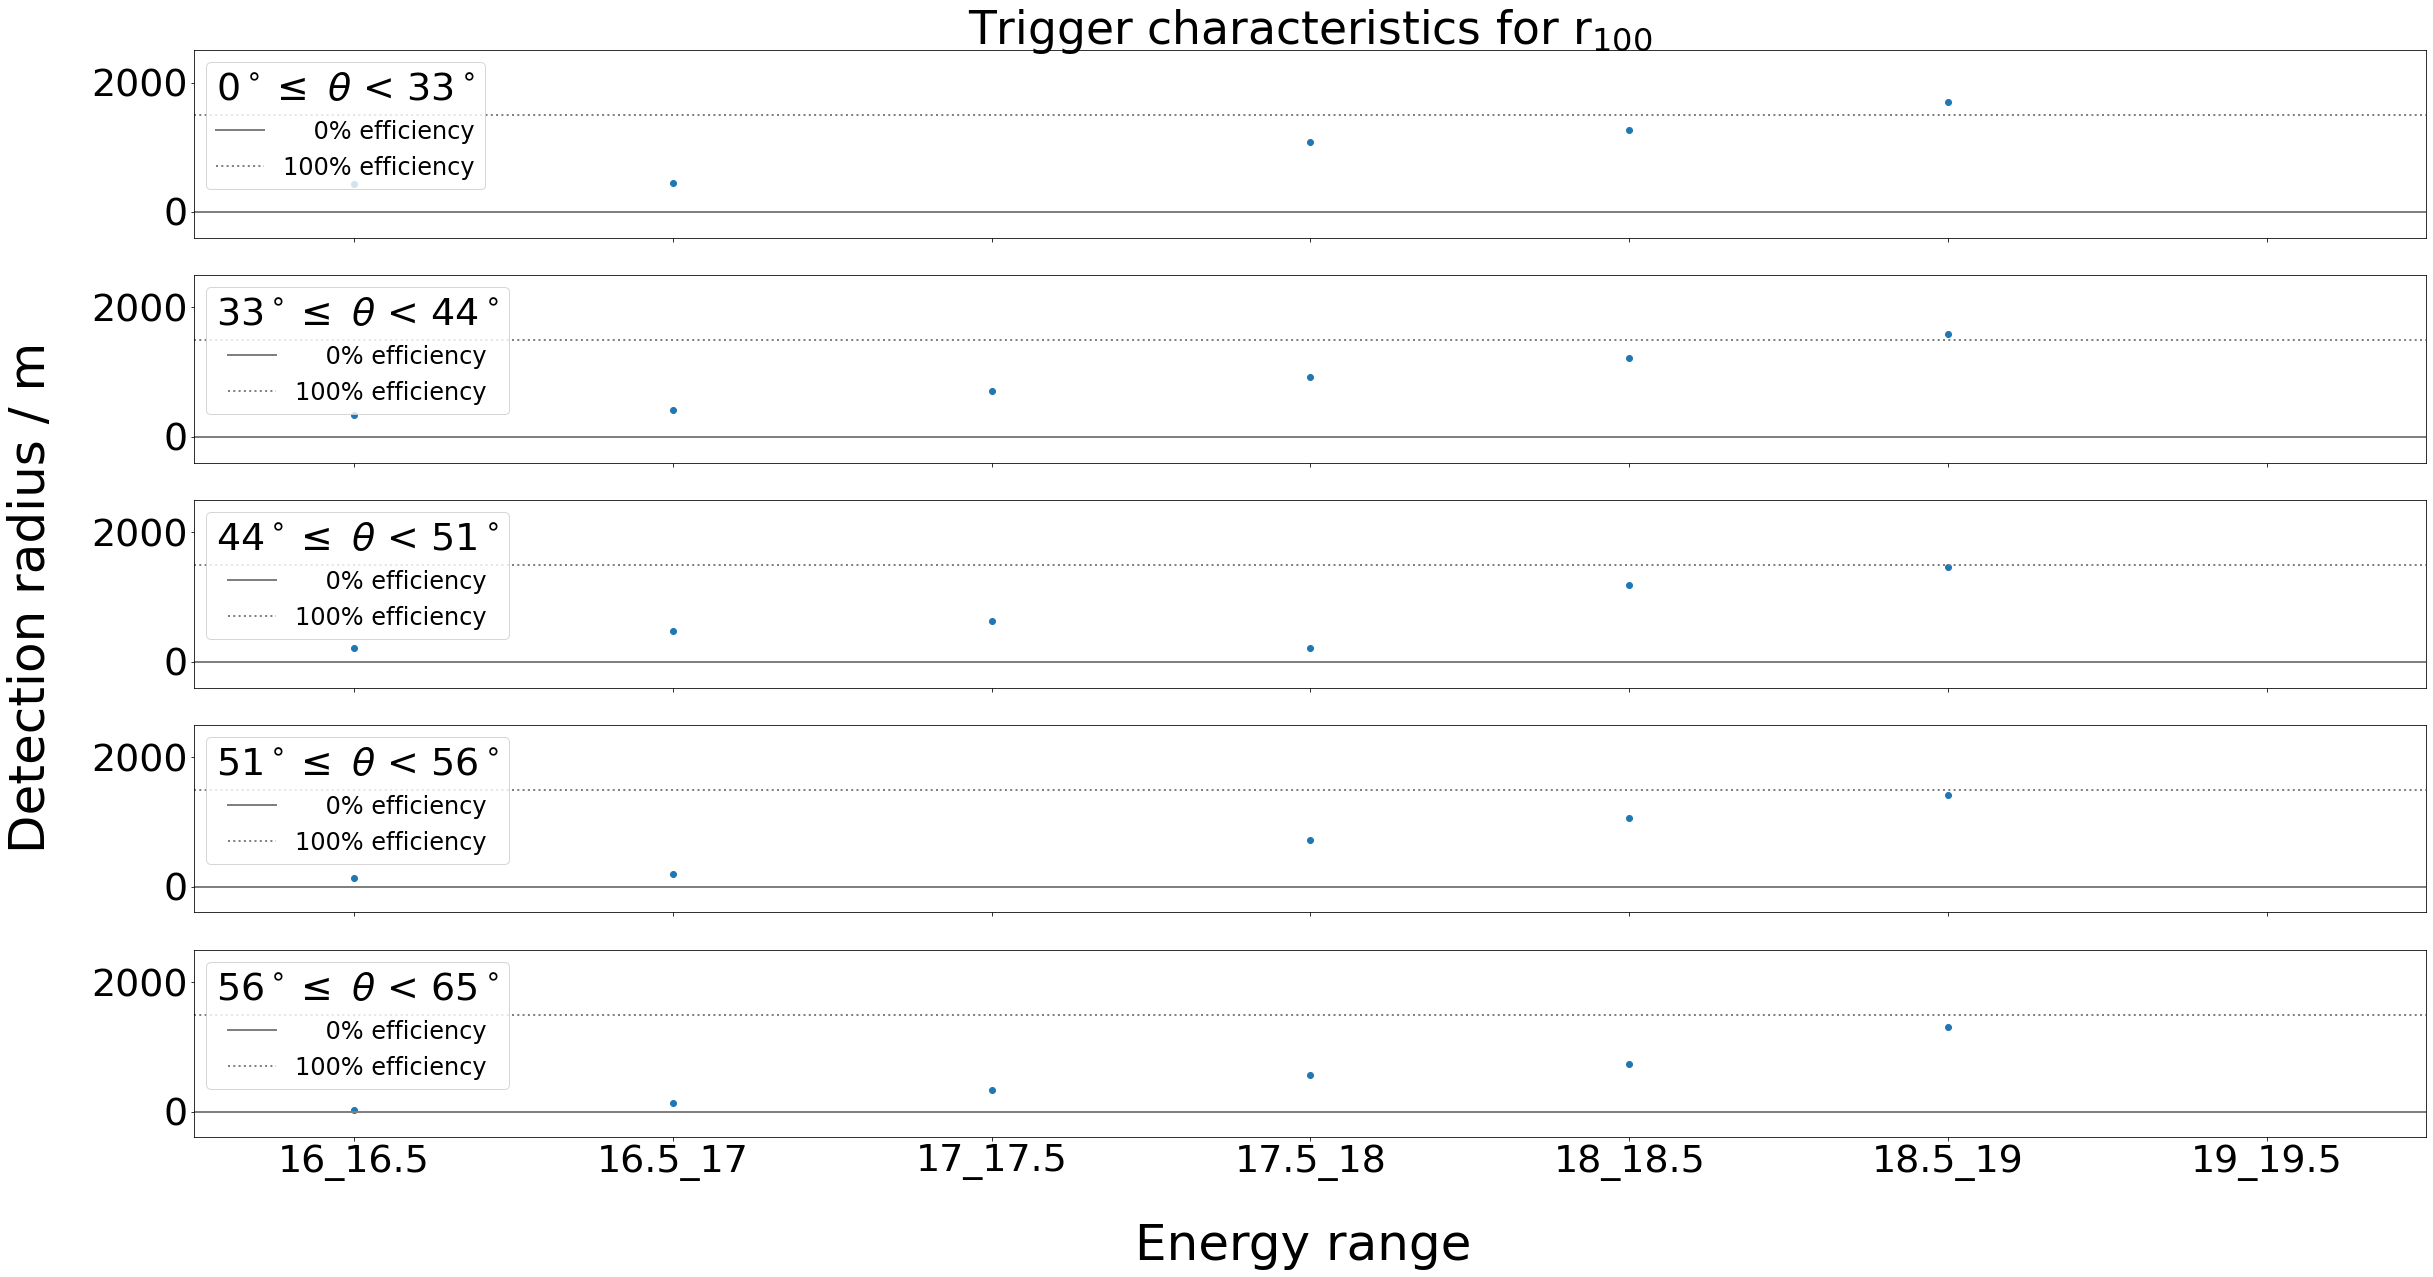

In [37]:
confidence_comparison(1, all_popt)